# Forecasting prices

## Overview

Train several models to see what's the better performance.

Models:

* KNN
* ARIMA Model
* Bagging
* Boosting

## Import libraries

In [1]:
import sys
!{sys.executable} -m  conda install -c anaconda pandas_datareader

/home/emi/miniconda3/envs/factors/bin/python: No module named conda


In [76]:
import datetime as dt
import os
import pandas as pd
import numpy as np
import csv
import warnings
from pandas import Series


# Files
from indicators import get_momentum, get_RSI, get_sma, plot_stock_prices_prediction
from util import fetchOnlineData, slice_df

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import tree, metrics, neighbors

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# ARIMA
import statsmodels
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf

# LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import tensorflow as tf # This code has been tested with TensorFlow 1.6


# Add plotly for interactive charts
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools



## Initial variables

In [13]:
symbol = "AABA"

# We'll look back 365 days
start_d = dt.date.today() - dt.timedelta(365)

## Getting data from Yahoo

In [14]:
yesterday = dt.date.today() - dt.timedelta(1)
portf_value = fetchOnlineData(start_d, symbol, yesterday)

[*********************100%***********************]  1 of 1 downloaded


In [ ]:
# Normalize the prices Dataframe
normed = portf_value.copy()

In [ ]:
# Convert price column to float
#normed[symbol] = pd.to_numeric(normed[symbol], downcast='float', errors='coerce').fillna(0)

In [ ]:
normed.info()
normed.head()

## Getting indicator values

In [10]:
def get_indicators(normed, symbol):

    # Compute momentum
    sym_mom = get_momentum(normed[symbol], window=10)

    # ****Relative Strength Index (RSI)****
    # Compute RSI
    rsi_value = get_RSI(normed[symbol], 7)

    # ****Simple moving average (SMA)****
    # Compute SMA
    sma, q = get_sma(normed[symbol], window=10)
    return sym_mom, sma, q, rsi_value

#normed = scaling_data(normed, symbol)

normed['date'] = portf_value.index
normed.set_index('date', inplace=True)
normed.rename(columns={'Adj Close': symbol}, inplace=True)


In [11]:
# Get indicators
sym_mom, sma, q, rsi_value = get_indicators(normed, symbol)


# Create momentum column
normed['Momentum'] = sym_mom

# Create SMA column
normed['SMA'] = sma

# Create SMA column
normed['RSI'] = rsi_value

date
2018-02-05   -0.022249
2018-02-06   -0.039702
2018-02-07   -0.072613
2018-02-08   -0.120005
2018-02-09   -0.122291
2018-02-12   -0.103857
2018-02-13   -0.088923
2018-02-14   -0.077867
2018-02-15   -0.021181
2018-02-16   -0.011962
2018-02-20    0.028686
2018-02-21    0.021488
2018-02-22    0.046563
2018-02-23    0.124512
2018-02-26    0.107832
2018-02-27    0.070745
2018-02-28    0.049642
2018-03-01    0.001086
2018-03-02   -0.022984
2018-03-05   -0.000952
2018-03-06    0.007776
2018-03-07    0.011583
2018-03-08    0.002781
2018-03-09   -0.014660
2018-03-12   -0.006660
2018-03-13   -0.002102
2018-03-14    0.031396
2018-03-15    0.077027
2018-03-16    0.099188
2018-03-19    0.059913
                ...   
2018-12-06    0.048777
2018-12-07    0.013837
2018-12-10   -0.002724
2018-12-11   -0.027963
2018-12-12   -0.020885
2018-12-13   -0.040807
2018-12-14   -0.037411
2018-12-17   -0.084007
2018-12-18   -0.115235
2018-12-19   -0.109568
2018-12-20   -0.111964
2018-12-21   -0.116807
2018-1

In [12]:
normed.info()
# Clean nan values
normed = normed.fillna(0)

# Sort dataframe by index
normed.sort_index()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2018-01-22 to 2019-01-18
Data columns (total 4 columns):
AABA        251 non-null float64
Momentum    241 non-null float64
SMA         242 non-null float64
RSI         251 non-null float64
dtypes: float64(4)
memory usage: 9.8 KB


,AABA,Momentum,SMA,RSI
date,,,,
2018-01-22,74.160004,0.000000,0.000000,56.776549
2018-01-23,76.570000,0.000000,0.000000,56.776549
2018-01-24,77.809998,0.000000,0.000000,56.776549
2018-01-25,78.580002,0.000000,0.000000,56.776549
2018-01-26,80.300003,0.000000,0.000000,56.776549
2018-01-29,79.339996,0.000000,0.000000,56.776549
2018-01-30,78.269997,0.000000,0.000000,56.776549
2018-01-31,79.879997,0.000000,0.000000,62.004931
2018-02-01,76.010002,0.000000,0.000000,46.299349


In [13]:
#missing data
total = normed.isnull().sum().sort_values(ascending=False)
percent = (normed.isnull().sum()/normed.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(missing_data)

          Total  Percent
RSI           0      0.0
SMA           0      0.0
Momentum      0      0.0
AABA          0      0.0


In [14]:
corr_df = normed.corr(method='pearson')
print("--------------- CORRELATIONS ---------------")
print(corr_df)

# Define X and y
feature_cols = ['Momentum', 'RSI']
X = normed[feature_cols]
y = normed[symbol]

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=False)

--------------- CORRELATIONS ---------------
              AABA  Momentum       SMA       RSI
AABA      1.000000  0.300007  0.187497  0.437419
Momentum  0.300007  1.000000 -0.008723  0.847988
SMA       0.187497 -0.008723  1.000000 -0.024710
RSI       0.437419  0.847988 -0.024710  1.000000


# Decision Tree Regressor

In [15]:
'''
# Use only to get the best parameter for max_depth
# Loop through a few different max depths and check the performance
for d in [3, 5, 10]:
    # Create the tree and fit it
    decision_tree = tree.DecisionTreeRegressor(max_depth=d)
    decision_tree.fit(X_train, y_train)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print(decision_tree.score(X_train, y_train))
    print(decision_tree.score(X_test, y_test), '\n')
'''

"\n# Use only to get the best parameter for max_depth\n# Loop through a few different max depths and check the performance\nfor d in [3, 5, 10]:\n    # Create the tree and fit it\n    decision_tree = tree.DecisionTreeRegressor(max_depth=d)\n    decision_tree.fit(X_train, y_train)\n\n    # Print out the scores on train and test\n    print('max_depth=', str(d))\n    print(decision_tree.score(X_train, y_train))\n    print(decision_tree.score(X_test, y_test), '\n')\n"

"\n# Use only to get the best parameter for max_depth\n# Loop through a few different max depths and check the performance\nfor d in [3, 5, 10]:\n    # Create the tree and fit it\n    decision_tree = tree.DecisionTreeRegressor(max_depth=d)\n    decision_tree.fit(X_train, y_train)\n\n    # Print out the scores on train and test\n    print('max_depth=', str(d))\n    print(decision_tree.score(X_train, y_train))\n    print(decision_tree.score(X_test, y_test), '\n')\n"

In [16]:
def model_fit_pred(X_train, y_train, X_test):
    '''Fit a model and get predictions and metrics'''
    
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Measuring predictions

    # Accuracy
    scores = cross_val_score(model, X_test, y_test, cv=10)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() / 2))

    # Coefficient of determination R^2
    '''
    The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.
    '''
    coef_deter = model.score(X_train, y_train)
    print('Coefficient of determination R^2: %s' % coef_deter)

    # Forecast error
    '''
    The units of the forecast error are the same as the units of the prediction. A forecast error of zero indicates no error, or perfect skill for that forecast.
    '''
    forecast_errors = [y_test[i] - y_pred[i] for i in range(len(y_test))]
    print('Forecast Errors: %s' % forecast_errors)

    # Forecast bias
    '''
    Mean forecast error, also known as the forecast bias. A forecast bias of zero, or a very small number near zero, shows an unbiased model.
    '''
    bias = sum(forecast_errors) * 1.0 / len(y_test)
    print('Bias: %f' % bias)

    # Mean absolute error
    '''
    A mean absolute error of zero indicates no error.
    '''
    mae = metrics.mean_absolute_error(y_test, y_pred)
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

    # Mean squared error
    '''
    A mean squared error of zero indicates perfect skill, or no error.
    '''
    mse = metrics.mean_squared_error(y_test, y_pred)
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

    # Root mean squared error
    '''
    As with the mean squared error, an RMSE of zero indicates no error.
    '''
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

    results = pd.DataFrame({'Price': y_test, 'Price prediction': y_pred})
    results.sort_index(inplace=True)

    return results, coef_deter, forecast_errors, bias, mae, mse, rmse

## Creating the model

In [17]:
model = tree.DecisionTreeRegressor(max_depth=10)
results, coef_deter, forecast_errors, bias, mae, mse, rmse = model_fit_pred(X_train, y_train, X_test)

Accuracy: -5.77 (+/- 2.28)
Coefficient of determination R^2: 0.9789414268921619
Forecast Errors: [-5.514288714285726, -6.124289714285723, -2.8075007500000027, -7.669998333333339, 0.29000100000000373, -12.369998999999993, -5.520001000000001, -10.740002000000004, -9.220002000000001, -9.329997999999996, -9.550002999999997, -3.6899950000000032, -8.433335333333332, -10.420001999999997, -11.525002000000008, -11.310001, -18.270004999999998, -10.987500750000002, -9.317498749999999, -13.010002000000007, -11.610000000000007, -13.995003000000004, -10.130001499999992, -9.45999899999999, -13.53499949999999, -9.360000499999991, -6.190002999999997, -15.819999999999993, -5.45000000000001, -9.077500750000006, -12.804285714285726, -6.379997000000003, -5.65000100000001, -13.040001000000004, -8.72999999999999, -10.534285714285723, -8.190003000000011, -8.07999749999999, -13.61, -14.699996999999996, -4.189993999999999, -16.93000099999999, -10.690003000000004, -16.020004999999998, -10.70999900000001, -5.6299

## Plotting predictioons

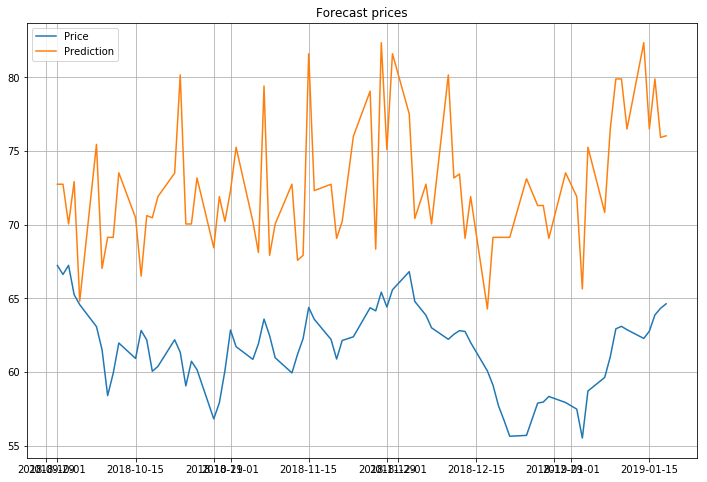

In [18]:
# Plot prediction
plt.figure(figsize=(12,8))
plt.plot(X_test.index, results['Price'], label='Price')
plt.plot(X_test.index,results['Price prediction'], label='Prediction')
plt.title("Forecast prices")
plt.legend()
plt.grid()
plt.show()

# KNN Model

## Creating the model

In [19]:
params = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}
knn = neighbors.KNeighborsRegressor()
print('KNN: %s' % knn)
model = GridSearchCV(knn, params, cv=5)

KNN: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')


In [154]:
results, coef_deter, forecast_errors, bias, mae, mse, rmse = model_fit_pred(X_train, y_train, X_test)

/home/emi/miniconda3py37/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/home/emi/miniconda3py37/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/home/emi/miniconda3py37/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/home/emi/miniconda3py37/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The defaul

Accuracy: -1.98 (+/- 1.82)
Coefficient of determination R^2: 0.5956085745851487
Forecast Errors: [-4.956670000000003, -4.946668333333335, -6.596664333333337, -5.983329999999995, -4.826665333333338, -6.046666666666667, -6.6066656666666645, -9.716665666666671, -10.620000666666677, -10.626666666666672, -11.466667333333326, -11.016662333333336, -9.540001666666669, -10.509998666666661, -8.953336333333347, -9.966666000000004, -9.97333566666667, -13.040000666666664, -10.483333333333334, -15.190002333333332, -14.063330999999998, -13.856669333333322, -12.066669000000005, -9.806665666666667, -12.826665999999996, -12.240001666666664, -9.219998999999994, -14.070002666666667, -8.669998999999997, -12.190001000000002, -15.409999333333332, -11.083333666666675, -11.086667333333331, -15.686668999999995, -8.900000333333324, -10.889999666666661, -13.416669666666671, -9.45333033333334, -8.543329333333332, -12.39333333333333, -11.806660666666659, -13.089999333333324, -11.340004000000008, -14.486671999999999

/home/emi/miniconda3py37/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



## Ploting predictions

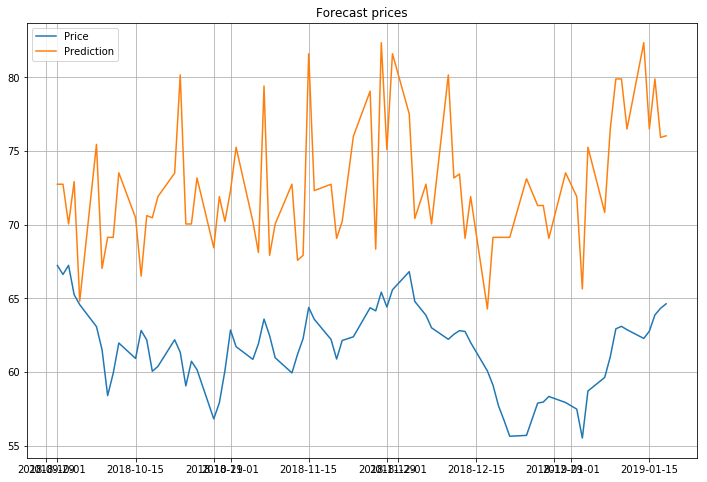

In [20]:
# Plot prediction
plt.figure(figsize=(12,8))
plt.plot(X_test.index, results['Price'], label='Price')
plt.plot(X_test.index,results['Price prediction'], label='Prediction')
plt.title("Forecast prices")
plt.legend()
plt.grid()
plt.show()

# ARIMA Model

In [21]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [22]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

## Getting best parameters values

In [27]:
# evaluate parameters
series =  pd.Series(normed[symbol].values)
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=97.420
ARIMA(0, 0, 1) MSE=29.873
ARIMA(0, 1, 0) MSE=1.885
ARIMA(0, 1, 1) MSE=1.864
ARIMA(0, 1, 2) MSE=1.846
ARIMA(0, 2, 0) MSE=3.310
ARIMA(0, 2, 1) MSE=1.923
ARIMA(0, 2, 2) MSE=1.898
ARIMA(1, 0, 0) MSE=1.960
ARIMA(1, 0, 2) MSE=1.934
ARIMA(1, 1, 0) MSE=1.871
ARIMA(1, 2, 0) MSE=3.047


## Fitting model and plotting

predicted=64.375608, expected=62.480000
predicted=63.232771, expected=60.980000
predicted=61.705952, expected=59.950001
predicted=60.655295, expected=61.209999
predicted=61.921743, expected=62.279999
predicted=62.995861, expected=64.389999
predicted=65.121704, expected=63.590000
predicted=64.304494, expected=62.220001
predicted=62.911334, expected=60.889999
predicted=61.559120, expected=62.150002
predicted=62.825546, expected=62.400002
predicted=63.070970, expected=64.370003
predicted=65.054790, expected=64.160004
predicted=64.835372, expected=65.430000
predicted=66.111563, expected=64.419998
predicted=65.084122, expected=65.589996
predicted=66.259282, expected=66.820000
predicted=67.494949, expected=64.800003
predicted=65.448003, expected=63.860001
predicted=64.492278, expected=63.009998
predicted=63.627743, expected=62.230000
predicted=62.834175, expected=62.570000
predicted=63.171635, expected=62.820000
predicted=63.418286, expected=62.759998
predicted=63.352073, expected=62.009998


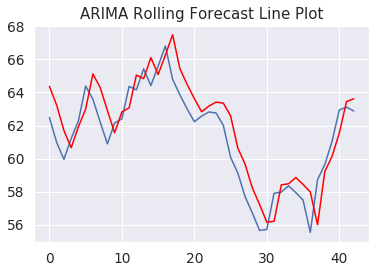

In [85]:


X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.title("ARIMA Rolling Forecast Line Plot")
plt.show()

## Showing summary

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  124
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -414.017
Method:                           css   S.D. of innovations              6.820
Date:                Thu, 17 Jan 2019   AIC                            832.033
Time:                        20:46:10   BIC                            837.674
Sample:                             1   HQIC                           834.324
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5090      0.612      0.831      0.408      -0.691       1.709


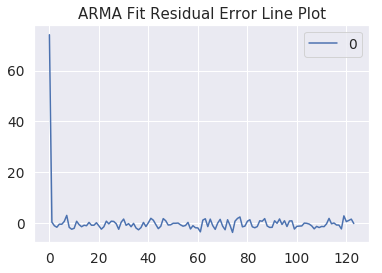

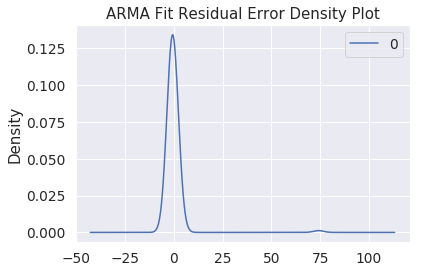

                  0
count  1.240000e+02
mean   9.463756e-16
std    6.847974e+00
min   -3.848948e+00
25%   -1.543951e+00
50%   -7.589516e-01
75%    5.510471e-01
max    7.415105e+01


In [95]:
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.title("ARMA Fit Residual Error Line Plot")
plt.show()
residuals.plot(kind='kde')
plt.title("ARMA Fit Residual Error Density Plot")
plt.grid("on")
plt.show()
print(residuals.describe())

## RMS

In [86]:
rms=np.sqrt(np.mean(np.power((np.array(history)-np.array(predictions)),2)))
print('RMS: ', rms)

RMS:  8.644035506873553


## Saving an ARIMA Time Series Forecasting Model

The statsmodels library provides an implementation of ARIMA for use in Python. ARIMA models can be saved to file for later use in making predictions on new data. There is a bug in the earlier versions to 0.9 of the statsmodels library that prevents saved models from being loaded.


In [87]:
print('statsmodels: %s' % statsmodels.__version__)

statsmodels: 0.9.0


In [88]:
# save model
model_fit.save('arima_model.pkl')


## Loading a model and predicting future prices

In [5]:
# load model
loaded = ARIMAResults.load('arima_model.pkl')
lookback_date = dt.date.today() - dt.timedelta(180)
start_d = dt.date.today()
#start_d = dt.datetime.strptime(start_d, '%Y-%m-%d')

end_d = dt.date.today() + dt.timedelta(7)
#end_d = dt.datetime.strptime(end_d, '%Y-%m-%d')

# Calculate steps
days = (end_d - start_d).days
forecast = loaded.forecast(steps=days)[0] 

# Setting dates for dataframe
dates = pd.date_range(start_d, periods=days)


df=pd.DataFrame(forecast)
df['Dates'] = dates
df.set_index('Dates', inplace=True)
df.rename(columns = {0:'Price'}, inplace=True)


/home/emi/miniconda3/envs/factors/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



## Plotting predictions

In [16]:
dates = pd.date_range(lookback_date, dt.date.today())
df_prices = slice_df(portf_value, dates)


In [1]:
# plot
plt.figure(figsize=(12,8))
plt.plot(df_prices.index, df_prices['Adj Close'], label='Price')
plt.plot(df, label='Prediction')
plt.legend()


NameError: name 'plt' is not defined

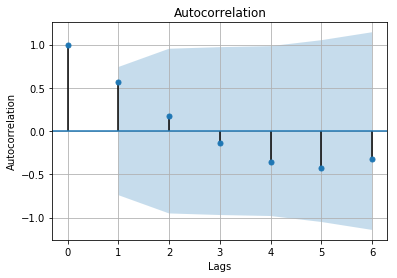

In [18]:


plot_acf(df['Price'])
plt.grid(True)
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.show()

# LSTM Long Short-Term Memory

LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is because LSTM is able to store past information that is important, and forget the information that is not. LSTM has three gates:

    The input gate: The input gate adds information to the cell state
    The forget gate: It removes the information that is no longer required by the model
    The output gate: Output Gate at LSTM selects the information to be shown as output


In [57]:
n = len(portf_value) * 60 / 100
print(len(portf_value))

#creating train and test sets
dataset = portf_value.values

train_data = dataset[:250]
test_data = dataset[250:]


251


In [63]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [64]:
print(test_data)

[[64.639999]]


In [66]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 10
for di in range(0,200,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [67]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [69]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(250):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [72]:
window_size = 10
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        #date = portf_value.loc[pred_idx,'Date']
        date = portf_value[portf_value.index == pred_idx]

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00081


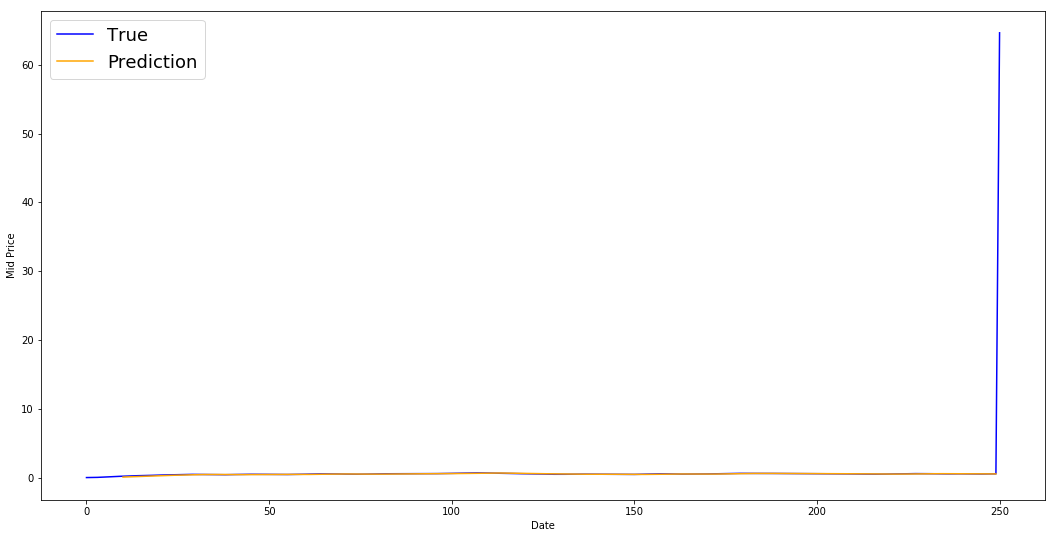

In [73]:
plt.figure(figsize = (18,9))
plt.plot(range(portf_value.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

# Introduction to LSTMs: Making Stock Movement Predictions Far into the Future

In [85]:
n = len(portf_value) * 60 / 100
print(len(portf_value))

#creating train and test sets
dataset = portf_value.values

train_data = dataset[:250]
test_data = dataset[250:]

251


In [74]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.         0.4666346  0.58921784 0.4472664  0.58246535]

	Output: [0.02743694 0.45790228 0.58921784 0.45677367 0.5704677 ]


Unrolled index 1
	Inputs:  [0.00392508 0.4615038  0.5980448  0.45119736 0.5747377 ]

	Output: [0.04884859 0.45040604 0.62119424 0.45119736 0.5747377 ]


Unrolled index 2
	Inputs:  [0.01300975 0.45790228 0.60921425 0.452872   0.572731  ]

	Output: [0.10057846 0.44234413 0.60921425 0.452872   0.56631494]


Unrolled index 3
	Inputs:  [0.02743694 0.45040604 0.62119424 0.45677367 0.5735043 ]

	Output: [0.07414001 0.45040604 0.6454323  0.47685814 0.5659872 ]


Unrolled index 4
	Inputs:  [0.04884859 0.44234413 0.6338735  0.46536627 0.5704677 ]

	Output: [0.15609127 0.45458728 0.6749511  0.46536627 0.56238174]


## Defining Hyperparameters

In [77]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.reset_default_graph() # This is important in case you run this multiple times

## Defining Inputs and Outputs

In [78]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

## Defining Parameters of the LSTM and Regression layer

In [79]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

## Calculating LSTM output and Feeding it to the regression layer to get final prediction

In [80]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

## Loss Calculation and Optimizer

In [81]:
# When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


## Prediction Related Calculations

In [82]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


## Running the LSTM

In [87]:
epochs = 30
valid_summary = 1 # Interval you make test predictions

n_predict_once = 50 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)

x_axis_seq = []

# Points you start your test predictions from
test_points_seq = np.arange(100,200,50).tolist()

for ep in range(epochs):       

    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):

        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))

      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))

      train_mse_ot.append(average_loss)

      average_loss = 0 # reset loss

      predictions_seq = []

      mse_test_loss_seq = []

      # ===================== Updating State and Making Predicitons ========================
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []

        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]

        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_mid_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)

        feed_dict = {}

        current_price = all_mid_data[w_i-1]

        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)

        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)

          our_predictions.append(np.asscalar(pred))

          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2

        session.run(reset_sample_states)

        predictions_seq.append(np.array(our_predictions))

        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)

        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)

      current_test_mse = np.mean(mse_test_loss_seq)

      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0

      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')

/home/emi/miniconda3/envs/factors/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning:

An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).



Initialized


ZeroDivisionError: division by zero